In [ ]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.6/720.6 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import torch.nn as nn

import pytorch_lightning as pl
import torchvision
from torchvision.datasets import MNIST
import os

from matplotlib import pyplot as plt

from torch.utils.data import DataLoader, random_split

class Encoder(nn.Module):

  def __init__(self, input_shape, num_hidden, latent_dim):
    super().__init__()
    self.latent_dim = latent_dim
    self.linear1 = nn.Linear(input_shape, num_hidden)
    self.relu1 = nn.ReLU()
    self.linear2 = nn.Linear(num_hidden, latent_dim)
    self.relu2 = nn.ReLU()
    self.latent_space = nn.Linear(latent_dim, latent_dim)


  def forward(self, x):
    x = self.linear1(x)
    x = self.relu1(x)
    x = self.linear2(x)
    x = self.relu2(x)
    x = self.latent_space(x)
    return x



class Decoder(nn.Module):

  def __init__(self, input_shape, num_hidden, latent_dim):
    super().__init__()
    self.latent_space = nn.Linear(latent_dim, latent_dim)
    self.relu1 = nn.ReLU()
    self.linear1 = nn.Linear(latent_dim, num_hidden)
    self.relu2 = nn.ReLU()
    self.linear2 = nn.Linear(num_hidden, input_shape)
    self.sigmoid = nn.Sigmoid()

  def forward(self, z):
    x = self.latent_space(z)
    x = self.relu1(x)
    x = self.linear1(x)
    x = self.relu1(x)
    x = self.linear2(x)
    x = self.sigmoid(x)
    return x

# Create a PyTorch Lightning class
class AutoEncoder(pl.LightningModule):
    def __init__(self, input_shape, num_hidden, latent_dim):
        super().__init__()
        self.input_shape = input_shape
        self.num_hidden = num_hidden
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_shape, num_hidden, latent_dim)
        self.decoder = Decoder(input_shape, num_hidden, latent_dim)

    def forward(self, x):
        # Forward pass
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


    def add_noise(self, x):
      # Add random noise
      noise = torch.randn_like(x)
      x_noisy = x + noise
      return x_noisy

    def training_step(self, batch, batch_idx):
        # Training step
        x, y = batch
        x_noisy = self.add_noise(x)
         # transformer un tenseur multidimensionnel en un tenseur unidimensionnel,
        x_noisy = nn.Flatten()(x_noisy)
        x = nn.Flatten()(x)
        z = self.encoder(x_noisy)
        x_hat = self.decoder(z)
         # Mesure l'erreur quadratique moyenne par élément.
        loss = nn.functional.mse_loss(x_hat, x)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # Validation step
        x, y = batch
        # Modifier pour rajouter noise
        x_noisy = self.add_noise(x)
        # transformer un tenseur multidimensionnel en un tenseur unidimensionnel,
        x = nn.Flatten()(x)
        x_noisy = nn.Flatten()(x_noisy)
        z = self.encoder(x_noisy)
        x_hat = self.decoder(z)
        # Mesure l'erreur quadratique moyenne par élément.
        loss = nn.functional.mse_loss(x_hat, x)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Testing step
        x, y = batch
        x_noisy = self.add_noise(x)
        x = nn.Flatten()(x)
        x_noisy = nn.Flatten()(x_noisy)
        z = self.encoder(x_noisy)
        x_hat = self.decoder(z)
        loss = nn.functional.mse_loss(x_hat, x)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        # Plot the first 8 images in the batch
        if batch_idx == 0:
            self.images = x_noisy[:8]
            self.zs = z[:8]
            self.reconstructions = x_hat[:8]
        return loss

    # final step after training to print original images and the results in the latent space
    def on_test_end(self):
      for i, (im, z, recon) in enumerate(zip(self.images, self.zs, self.reconstructions)):
            im = im.reshape(28, 28)
            recon = recon.reshape(28, 28)
            w = self.latent_dim//8
            z = z.reshape(8, w)
            plt.subplot(8, 3, i*3 + 1)
            if i==0: plt.title("Image")
            plt.imshow(im.detach().cpu().numpy(), cmap="gray")
            plt.axis("off")
            plt.subplot(8, 3, i*3 + 2)
            if i==0: plt.title("Latent Representation")
            plt.imshow(z.detach().cpu().numpy(), cmap="gray")
            plt.axis("off")
            plt.subplot(8, 3, i*3 + 3)
            if i==0: plt.title("Reconstruction")
            plt.imshow(recon.detach().cpu().numpy(), cmap="gray")
            plt.axis("off")



In [ ]:
# Create the datamodule for MNIST dataset
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = "./", batch_size=32):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                         torchvision.transforms.Normalize((0.1307,), (0.3081,))])

    def prepare_data(self):
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage: str):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit":
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            # split data into train and validation
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test":
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
      # DataLoader => Combines a dataset and a sampler
        return DataLoader(self.mnist_train, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size)

In [ ]:
# Create the model
model = AutoEncoder(input_shape=28*28, num_hidden=128 , latent_dim=64)
dataset = MNISTDataModule(data_dir = os.getcwd(), batch_size=32)
trainer = pl.Trainer(max_epochs=10, accelerator="gpu", devices=-1)
trainer.fit(model, dataset)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


100%|██████████| 9912422/9912422 [00:00<00:00, 108850617.99it/s]


Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 38887863.19it/s]


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24396743.98it/s]


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23665253.13it/s]


Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 112 K 
1 | decoder | Decoder | 113 K 
------------------------------------
226 K     Trainable params
0         Non-trainable params
226 K     Total params
0.906     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_0/checkpoints/epoch=9-step=17190.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_0/checkpoints/epoch=9-step=17190.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     0.537187397480011     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.537187397480011}]

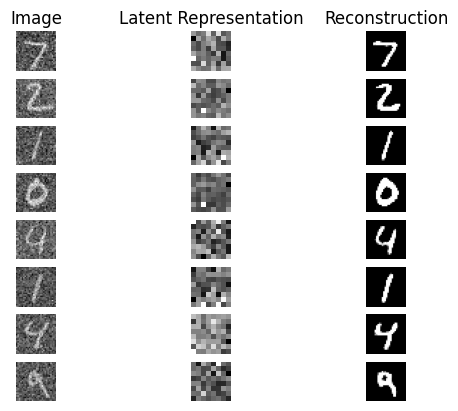

In [ ]:
dataset.setup(stage="test")
trainer.test(datamodule=dataset)